In [1]:
%load_ext Cython

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

from tqdm import tqdm
from scipy.special import erfc
import boost_histogram as bh

from lmfit.models import *
from lmfit import Model

import inspect

In [3]:
golden_df = pd.read_csv("/Users/tylern/Data/e1d/gr.csv")

#golden_df = golden_df.groupby(golden_df['run_num'], as_index=False).aggregate({'run_num': 'first', 'num_elec': 'sum', 'num_of_events': 'sum', 'total_q': 'sum'})
golden_df['ratio'] = golden_df['num_elec'] / golden_df['total_q']
golden_df['run'] = golden_df.run_num*10 + golden_df.file_num
golden_df = golden_df.sort_values(by=['run_num', 'file_num']).reset_index()
# golden_df = golden_df.sort_values(by=['run_num']).reset_index()
# golden_df['sum_q'] = np.cumsum(golden_df['total_q'])
golden_df = golden_df.groupby("run_num").sum().reset_index()
print(len(golden_df))

golden_df.head()

133


,run_num,index,file_num,num_elec,num_of_events,total_q,_ratio,ratio,run
0,22848,1,11,19231,206200.0,34.602299,47939.627004,4461.905920,456971
1,22853,90,66,133604,1389076.0,220.698300,132153.240642,12695.050948,2742426
2,22884,80,10,63403,617950.0,64.988001,71289.618347,7294.084672,1144210
3,22886,264,55,153747,1502621.0,284.785698,99725.461629,10162.458246,2517515
4,22894,231,21,63411,690850.0,62.951100,121095.154202,11281.609269,1602601


In [4]:
run_list = pd.read_csv("/Users/tylern/Data/e1d/out.csv").rename(columns={"Run Id": "run_num"})
run_list['Number of Events'] = pd.to_numeric(run_list['Number of Events'], errors='coerce')
run_list.head()

,run_num,Start Date,Beam Energy,Beam Current Request,Torus Current,Mini-Torus Current,Number of Events,Run Type,Target
0,22678,2000-01-31 10:16:00.0,1645.03,0.0,0.977,0,27380.0,e_calib_misc,56Fe
1,22679,2000-01-31 10:29:00.0,1645.03,0.0,0.977,0,32546.0,e_calib_misc,56Fe
2,22680,2000-01-31 10:35:00.0,1645.03,0.0,0.977,0,555588.0,e_calib_misc,56Fe
3,22681,2000-01-31 14:47:00.0,1645.03,0.0,-0.977,0,980.0,e_calib_misc,other
4,22682,2000-01-31 14:52:00.0,1645.03,0.0,0.977,0,1133.0,e_calib_misc,other


In [5]:
golden = pd.merge(golden_df, run_list, on='run_num')
#golden = golden_df
empty = golden[golden.Target == "empty"]
golden = golden[(golden.Target == "H2_full") & (golden["Run Type"] == 'beam_electron')]
golden.dropna(inplace=True)
print(len(golden))
golden.head(10)

133


,run_num,index,file_num,num_elec,num_of_events,total_q,_ratio,ratio,run,Start Date,Beam Energy,Beam Current Request,Torus Current,Mini-Torus Current,Number of Events,Run Type,Target
0,22848,1,11,19231,206200.0,34.602299,47939.627004,4461.905920,456971,2000-02-04 02:20:00.0,4817.26,5.0,3376.80,5996,5061135.0,beam_electron,H2_full
1,22853,90,66,133604,1389076.0,220.698300,132153.240642,12695.050948,2742426,2000-02-04 05:30:00.0,4817.26,5.0,3376.80,5996,4961938.0,beam_electron,H2_full
2,22884,80,10,63403,617950.0,64.988001,71289.618347,7294.084672,1144210,2000-02-05 02:31:00.0,4817.26,4.0,3372.89,5996,2054237.0,beam_electron,H2_full
3,22886,264,55,153747,1502621.0,284.785698,99725.461629,10162.458246,2517515,2000-02-05 04:08:00.0,4817.26,4.0,3376.80,5996,5015053.0,beam_electron,H2_full
4,22894,231,21,63411,690850.0,62.951100,121095.154202,11281.609269,1602601,2000-02-05 10:08:00.0,4817.26,4.0,3374.85,5996,3146650.0,beam_electron,H2_full
5,22895,462,55,106206,1183992.0,141.866597,152100.642948,13685.064846,2518505,2000-02-05 11:16:00.0,4817.26,4.0,3378.75,5996,5069290.0,beam_electron,H2_full
6,22904,525,45,98058,1088077.0,117.693198,149058.266258,13507.065202,2290445,2000-02-05 17:10:00.0,4817.26,5.0,3374.85,5996,5065727.0,beam_electron,H2_full
7,22905,238,6,35071,389423.0,20.536299,100863.149288,9059.461891,916206,2000-02-05 18:34:00.0,4817.26,5.0,3376.80,5996,1682063.0,beam_electron,H2_full
8,22906,1595,231,242141,2582854.0,542.351300,204701.616151,19249.142962,5039551,2000-02-05 19:35:00.0,4817.26,5.0,3376.80,5996,10054593.0,beam_electron,H2_full
9,22907,1974,210,224458,2406864.0,490.200205,202407.132968,18929.267633,4810680,2000-02-05 22:28:00.0,4817.26,5.0,3374.85,5996,9361598.0,beam_electron,H2_full


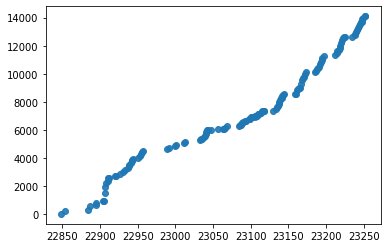

In [6]:
plt.scatter(golden['run_num'], np.cumsum(golden['total_q']), alpha=0.9);

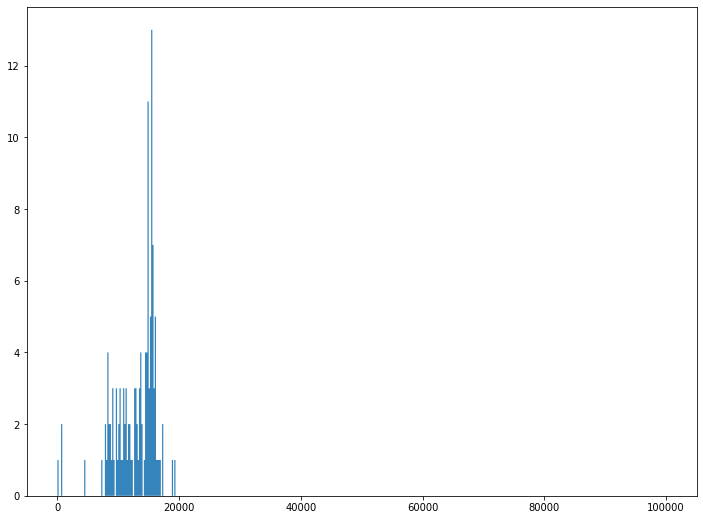

In [7]:
SIGMA = 3
fig = plt.figure(figsize=(12,9), facecolor='w', edgecolor='k')
bin_heights, bin_borders, _ = plt.hist(golden['ratio'], bins=500, histtype='stepfilled', alpha=0.9, range=[0,100000])#, range=[40_000, 80_000])

# x = bin_borders[:-1]
# y = bin_heights

# mod = GaussianModel()
# pars = mod.guess(y, x=x)
# pars['center'].set(value=6_000)
# out = mod.fit(y, pars, x=x)

# #xs=np.linspace(4_000, 20_000, 140)

# plt.plot(xs, out.eval(x=xs), 'r-', label='best fit')

# center = out.params['center'].value
# fwhm = out.params['fwhm'].value

# print(out.params)

# plt.axvline(x=center, c='r', alpha=0.3)
# plt.axvline(x=center+SIGMA*fwhm, c='r', alpha=0.3)
# plt.axvline(x=center-SIGMA*fwhm, c='r', alpha=0.3)

# #plt.ylim(0)
# plt.xlabel('Ratio')
plt.show()

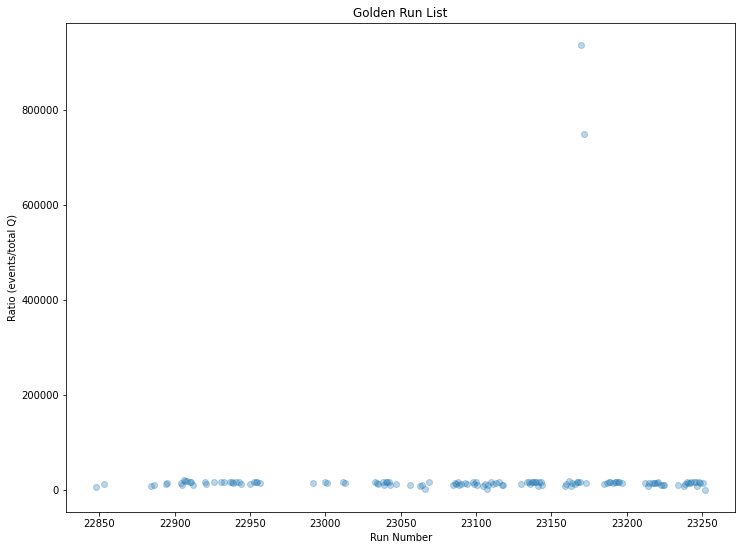

In [8]:
fig = plt.figure(num=None, figsize=(12,9), facecolor='w', edgecolor='k')
plt.scatter(golden['run_num'], golden['ratio'], alpha=0.3)
#print(center)
#plt.axhline(y=center)
#plt.axhline(y=center+SIGMA*fwhm)
#plt.axhline(y=center-SIGMA*fwhm)
plt.xlabel('Run Number')
plt.title('Golden Run List')
plt.ylabel('Ratio (events/total Q)')
#plt.ylim([40_000, 80_000])
#plt.ylim([-1000, 80_000])
plt.show()


In [9]:
runs = golden[(golden['ratio'] >= center-SIGMA*fwhm) & (golden['ratio'] <= center+SIGMA*fwhm)].run_num
cut_out = golden[~golden.run_num.isin(runs.values)]
after_cut = golden[golden.run_num.isin(runs.values)]
print(len(after_cut))
after_cut.head()

NameError: name 'center' is not defined

In [ ]:
fig = plt.figure(num=None, figsize=(12,9), facecolor='w', edgecolor='k')
plt.scatter(after_cut['run_num'], after_cut['ratio'], alpha=0.5)
plt.scatter(cut_out['run_num'], cut_out['ratio'], alpha=0.5)
plt.scatter(empty['run_num'], empty['ratio'], alpha=0.5)
plt.axhline(y=center)
plt.axhline(y=center+SIGMA*fwhm)
plt.axhline(y=center-SIGMA*fwhm)
plt.xlabel('Run Number')
plt.title('Golden Run List')
plt.ylabel('Ratio (events/total Q)')
#plt.ylim([40_000, 80_000])
plt.ylim([0, 40_000])
plt.show()


fig = plt.figure(num=None, figsize=(12,9), facecolor='w', edgecolor='k')
plt.scatter(golden.index, np.cumsum(golden['total_q']), alpha=0.9, label=f'{np.max(np.cumsum(golden.total_q))}')
plt.scatter(after_cut.index, np.cumsum(after_cut['total_q']), alpha=0.9, label=f'{np.max(np.cumsum(after_cut.total_q))}')
plt.legend()
plt.show()


#print(Q_tot := np.max(np.cumsum(after_cut.total_q)))
print(Q_tot := np.max(np.cumsum(golden.total_q)))

In [ ]:
def luminosity(Q_tot=2822.038E-6):
    Q_tot *= 1E-6
    # Q_tot = 15623.89E-6  # mCE-6 -> C
    # Q_tot = 2822.038E-6  # mCE-6 -> C
    l = 5  # cm
    rho = 0.0708  # g/cm3
    Avigadro = 6.022E23  # mol^−1
    qe = 1.602E-19  # C
    MH = 1.007  # g/mol
    conv_cm2_to_fm2 = 1E-39 # From wolfram alpha
    conv_cm2_to_mubarn = 1E-30

    return (Q_tot*l*rho*Avigadro)/(qe*MH) * conv_cm2_to_mubarn

In [ ]:
print(f'{Q_tot:0.10f}')
print(f'{luminosity(Q_tot=Q_tot):0.2e}')
print(f'{luminosity():0.2e}')

In [ ]:
from shutil import copyfile
import os
print(len(after_cut.run_num.unique()))
for run in after_cut.run_num.unique():
    #fil = int(fil)
    #src = f'/Volumes/LaCiE/physics/e1d/v2/H2_full/h10_r{run}_{fil:02d}.root'
    #dst = f'/Users/tylern/Data/e1d/golden_run/h10_r{run}_{fil:02d}.root'
    # copyfile(src, dst)
    #command = f"rsync workstation_tunnel:/work/gothelab/clas6/e1d/data/v2/h10_r{run}_*.root /Users/tylern/Data/e1d/golden_run"
    # command = f"rsync /Volumes/LaCiE/physics/e1d/v2/H2_full/h10_r{run}_*.root /Users/tylern/Data/e1d/golden_run"
    command = f"ln -s /work/gothelab/clas6/e1d/data/v2/h10_r{run}_*.root golden_run/;"
    print(command)
    #x = os.system(command)
    #print(x)
    

In [ ]:
for run in empty.run_num.unique():
    #fil = int(fil)
    #src = f'/Volumes/LaCiE/physics/e1d/v2/H2_full/h10_r{run}_{fil:02d}.root'
    #dst = f'/Users/tylern/Data/e1d/golden_run/h10_r{run}_{fil:02d}.root'
    # copyfile(src, dst)
    #command = f"rsync workstation_tunnel:/work/gothelab/clas6/e1d/data/v2/h10_r{run}_*.root /Users/tylern/Data/e1d/golden_run"
    # command = f"rsync /Volumes/LaCiE/physics/e1d/v2/H2_full/h10_r{run}_*.root /Users/tylern/Data/e1d/golden_run"
    command = f"ln -s /work/gothelab/clas6/e1d/data/v2/h10_r{run}_*.root empty/;"
    print(command)
    #x = os.system(command)
    #print(x)
    